In [1]:
!pip install gymnasium networkx numpy stable-baselines3 matplotlib
!pip install gym networkx numpy stable-baselines3 matplotlib

In [2]:
!pip install stable-baselines3
!pip install gym networkx numpy stable-baselines3 matplotlib
!pip install gymnasium
!pip install stable-baselines3[extra]
!pip install 'shimmy>=0.2.1'


In [3]:
import gymnasium as gym
from gymnasium import spaces
import networkx as nx
import numpy as np
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
from itertools import combinations


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# More than 1 odd cycle!

In [5]:
import gym
from gym import spaces
import networkx as nx
import numpy as np
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
from itertools import combinations


In [6]:
class OddCycleGraphEnv(gym.Env):
    def __init__(self, n_nodes):
        super(OddCycleGraphEnv, self).__init__()
        self.n_nodes = n_nodes
        self.target_edges = n_nodes * (n_nodes - 1) // 4  # Approximately half of the total possible edges
        self.action_space = spaces.Discrete(n_nodes * n_nodes)  # Add/Remove edges
        self.observation_space = spaces.Box(low=0, high=1, shape=(n_nodes, n_nodes), dtype=np.float32)
        self.reset()

    def reset(self):
        self.G = nx.Graph()
        self.G.add_nodes_from(range(self.n_nodes))
        # Initialize the graph with a minimum spanning tree to ensure it's connected
        mst = nx.minimum_spanning_tree(nx.complete_graph(self.n_nodes))
        self.G.add_edges_from(mst.edges())
        return nx.to_numpy_array(self.G)

    def step(self, action):
        i, j = divmod(action, self.n_nodes)
        if self.G.has_edge(i, j):
            self.G.remove_edge(i, j)
            reward = -1
        else:
            self.G.add_edge(i, j)
            reward = 1

        # Ensure the number of edges is approximately equal to the number of non-edges
        if len(self.G.edges) > self.target_edges:
            reward -= 5

        done = self.check_done()
        obs = nx.to_numpy_array(self.G)
        return obs, reward, done, {}

    def check_done(self):
        # Check for odd cycles using BFS
        for node in self.G:
            if self.bfs_check_odd_cycle(node):
                return True
        return False

    def bfs_check_odd_cycle(self, start):
        visited = {start: 0}
        queue = [(start, 0)]
        while queue:
            current_node, depth = queue.pop(0)
            for neighbor in self.G.neighbors(current_node):
                if neighbor not in visited:
                    visited[neighbor] = depth + 1
                    queue.append((neighbor, depth + 1))
                elif visited[neighbor] % 2 == depth % 2:
                    return True
        return False
    def check_odd_cycle_condition(G):
      odd_cycles = []

      # Find all cycles in the graph
      cycles = list(nx.cycle_basis(G))

      # Filter out the odd cycles
      for cycle in cycles:
          if len(cycle) % 2 == 1:
              odd_cycles.append(cycle)

      # Check for the odd cycle condition
      for cycle1, cycle2 in combinations(odd_cycles, 2):
          if not set(cycle1) & set(cycle2):  # No common vertices
              if not any(G.has_edge(u, v) for u in cycle1 for v in cycle2):
                  return False
      return True


    def render(self, mode='human'):
        plt.figure(figsize=(8, 6))
        np.random.seed(42)  # Set the seed for reproducibility
        pos = {i: np.random.rand(2) for i in range(self.n_nodes)}
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
        plt.show()


In [7]:
def check_odd_cycle_condition(G):
    odd_cycles = []

    # Find all cycles in the graph
    cycles = list(nx.cycle_basis(G))

    # Filter out the odd cycles
    for cycle in cycles:
        if len(cycle) % 2 == 1:
            odd_cycles.append(cycle)

    # Check for the odd cycle condition
    for cycle1, cycle2 in combinations(odd_cycles, 2):
        if not set(cycle1) & set(cycle2):  # No common vertices
            if not any(G.has_edge(u, v) for u in cycle1 for v in cycle2):
                return False
    return True

In [8]:
# Create and train the model
env = OddCycleGraphEnv(n_nodes=6)
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)
model.save("odd_cycle_graph_model")


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.5      |
|    ep_rew_mean     | 0.76     |
| time/              |          |
|    fps             | 257      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.32       |
|    ep_rew_mean          | 0.92       |
| time/                   |            |
|    fps                  | 208        |
|    iterations           | 2          |
|    time_elapsed         | 19         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.04772276 |
|    clip_fraction        | 0.423      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.55

In [9]:
# Evaluate the model
model = PPO.load("odd_cycle_graph_model")
obs = env.reset()
done = False
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


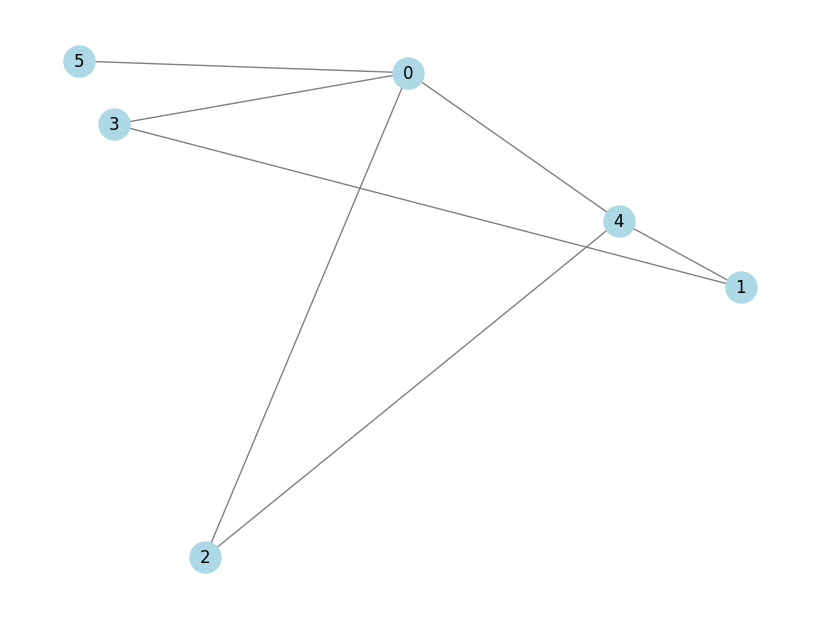

Graph satisfies the odd cycle condition: True


In [10]:
# Render the final graph
env.render()

# Check if the graph satisfies the odd cycle condition
satisfies_odd_cycle_condition = check_odd_cycle_condition(env.G)
print(f"Graph satisfies the odd cycle condition: {satisfies_odd_cycle_condition}")

The graph satifies the odd cycle condition, but it is not the best one. Since it has only 1 odd cycle. Trying to improve the grpah quality.

In [11]:
class OddCycleGraphEnv(gym.Env):
    def __init__(self, n_nodes):
        super(OddCycleGraphEnv, self).__init__()
        self.n_nodes = n_nodes
        self.target_edges = n_nodes * (n_nodes - 1) // 4  # Approximately half of the total possible edges
        self.action_space = spaces.Discrete(n_nodes * n_nodes)  # Add/Remove edges
        self.observation_space = spaces.Box(low=0, high=1, shape=(n_nodes, n_nodes), dtype=np.float32)
        self.reset()

    def reset(self):
        self.G = nx.Graph()
        self.G.add_nodes_from(range(self.n_nodes))
        # Initialize the graph with a minimum spanning tree to ensure it's connected
        mst = nx.minimum_spanning_tree(nx.complete_graph(self.n_nodes))
        self.G.add_edges_from(mst.edges())
        return nx.to_numpy_array(self.G)

    def step(self, action):
        i, j = divmod(action, self.n_nodes)
        if self.G.has_edge(i, j):
            self.G.remove_edge(i, j)
            reward = -1
        else:
            self.G.add_edge(i, j)
            reward = 1

        # Ensure the number of edges is approximately equal to the number of non-edges
        if len(self.G.edges) > self.target_edges:
            reward -= 5

        done = self.check_done()
        obs = nx.to_numpy_array(self.G)
        return obs, reward, done, {}

    def check_done(self):
        # Check for odd cycles using BFS
        for node in self.G:
            if self.bfs_check_odd_cycle(node):
                return True
        return False

    def bfs_check_odd_cycle(self, start):
        visited = {start: 0}
        queue = [(start, 0)]
        while queue:
            current_node, depth = queue.pop(0)
            for neighbor in self.G.neighbors(current_node):
                if neighbor not in visited:
                    visited[neighbor] = depth + 1
                    queue.append((neighbor, depth + 1))
                elif visited[neighbor] % 2 == depth % 2:
                    return True
        return False
    def count_odd_cycles(G):
      odd_cycles = []

      # Find all cycles in the graph
      cycles = list(nx.cycle_basis(G))

      # Filter out the odd cycles
      for cycle in cycles:
          if len(cycle) % 2 == 1:
              odd_cycles.append(cycle)

      return len(odd_cycles)

    def render(self, mode='human'):
        plt.figure(figsize=(8, 6))
        np.random.seed(42)  # Set the seed for reproducibility
        pos = {i: np.random.rand(2) for i in range(self.n_nodes)}
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
        plt.show()


In [12]:
def count_odd_cycles(G):
    odd_cycles = []

    # Find all cycles in the graph
    cycles = list(nx.cycle_basis(G))

    # Filter out the odd cycles
    for cycle in cycles:
        if len(cycle) % 2 == 1:
            odd_cycles.append(cycle)

    return len(odd_cycles)


In [13]:
# Create and train the model
env = OddCycleGraphEnv(n_nodes=15)
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)
model.save("odd_cycle_graph_model")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.09     |
|    ep_rew_mean     | 0.93     |
| time/              |          |
|    fps             | 399      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06        |
|    ep_rew_mean          | 0.96        |
| time/                   |             |
|    fps                  | 375         |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.098754086 |
|    clip_fraction        | 0.456       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.37       |
|    explained_variance   | -0.00377    |
|    learning_rate        | 0.

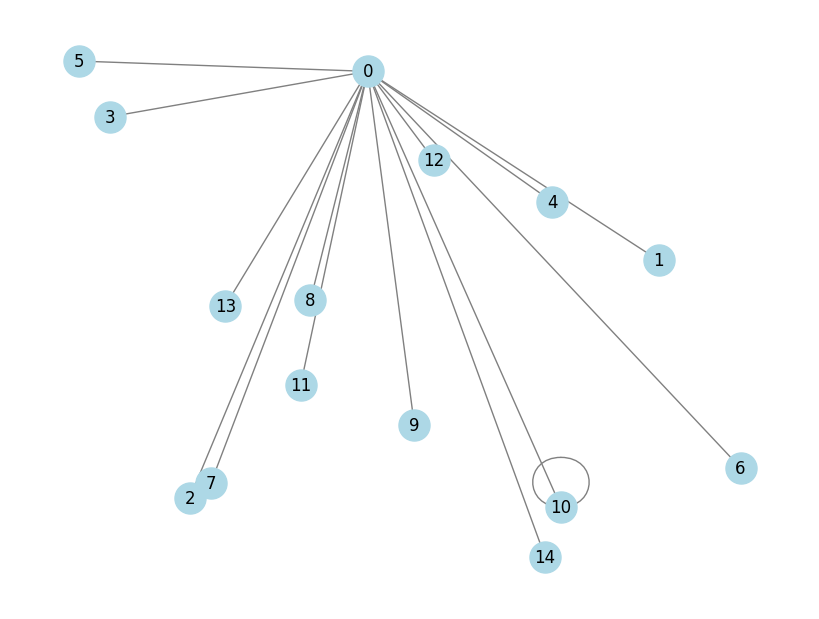

In [14]:
# Evaluate the model
model = PPO.load("odd_cycle_graph_model")
obs = env.reset()
done = False
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)

# Render the final graph
env.render()

The graph forms a tree like structure due to minimum spanning tree , used to make connected grapgh. Trying to form a graph not a tree.

In [15]:
class OddCycleGraphEnv(gym.Env):
    def __init__(self, n_nodes):
        super(OddCycleGraphEnv, self).__init__()    # Call the constructor of the parent class
        self.n_nodes = n_nodes  # Number of nodes in the graph
        self.target_edges = n_nodes * (n_nodes - 1) // 4  # Approximately half of the total possible edges
        self.action_space = spaces.Discrete(n_nodes * n_nodes)  # This is to control the edges in the graph
        self.observation_space = spaces.Box(low=0, high=1, shape=(n_nodes, n_nodes), dtype=np.float32)  # This is the observation space
        self.reset()

    def reset(self):
        self.G = nx.Graph()  # Initialize the graph
        self.G.add_nodes_from(range(self.n_nodes))  # Add nodes to the graph
        # Initialize the graph with a minimum spanning tree to ensure it's connected
        mst = nx.minimum_spanning_tree(nx.complete_graph(self.n_nodes))
        self.G.add_edges_from(mst.edges())  # Add edges to the graph
        return nx.to_numpy_array(self.G)

    def step(self, action):
        i, j = divmod(action, self.n_nodes)  # Convert the action to indices
        if self.G.has_edge(i, j):
            self.G.remove_edge(i, j)
            reward = -1
        else:
            self.G.add_edge(i, j)
            reward = 1

        # Encourage the formation of odd cycles
        num_odd_cycles = self.count_odd_cycles(self.G)
        if num_odd_cycles >= 2:
            reward += num_odd_cycles * 10  # Strongly reward having at least two odd cycles

        # Ensure the number of edges is approximately equal to the number of non-edges
        if len(self.G.edges) > self.target_edges:
            reward -= 5

        done = self.check_done(num_odd_cycles)  # Check if the episode is done
        obs = nx.to_numpy_array(self.G)
        return obs, reward, done, {}

    def check_done(self, num_odd_cycles):
        # Check if the number of odd cycles is at least 2
        return num_odd_cycles >= 2

    def bfs_check_odd_cycle(self, start):
        visited = {start: 0}
        queue = [(start, 0)]
        while queue:
            current_node, depth = queue.pop(0)
            for neighbor in self.G.neighbors(current_node):
                if neighbor not in visited:
                    visited[neighbor] = depth + 1
                    queue.append((neighbor, depth + 1))
                elif visited[neighbor] % 2 == depth % 2:
                    return True
        return False

    def count_odd_cycles(self, G):
        odd_cycles = []

        # Find all cycles in the graph
        cycles = list(nx.cycle_basis(G))

        # Filter out the odd cycles
        for cycle in cycles:
            if len(cycle) % 2 == 1:
                odd_cycles.append(cycle)
        return len(odd_cycles)

    def render(self, mode='human'):
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(self.G)
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
        plt.show()


In [16]:
# Create and train the model
env = OddCycleGraphEnv(n_nodes=10)  # Example with 10 nodes
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)
model.save("odd_cycle_graph_model")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.53     |
|    ep_rew_mean     | 21.7     |
| time/              |          |
|    fps             | 713      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.55       |
|    ep_rew_mean          | 21.8       |
| time/                   |            |
|    fps                  | 573        |
|    iterations           | 2          |
|    time_elapsed         | 7          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.02772222 |
|    clip_fraction        | 0.28       |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.59

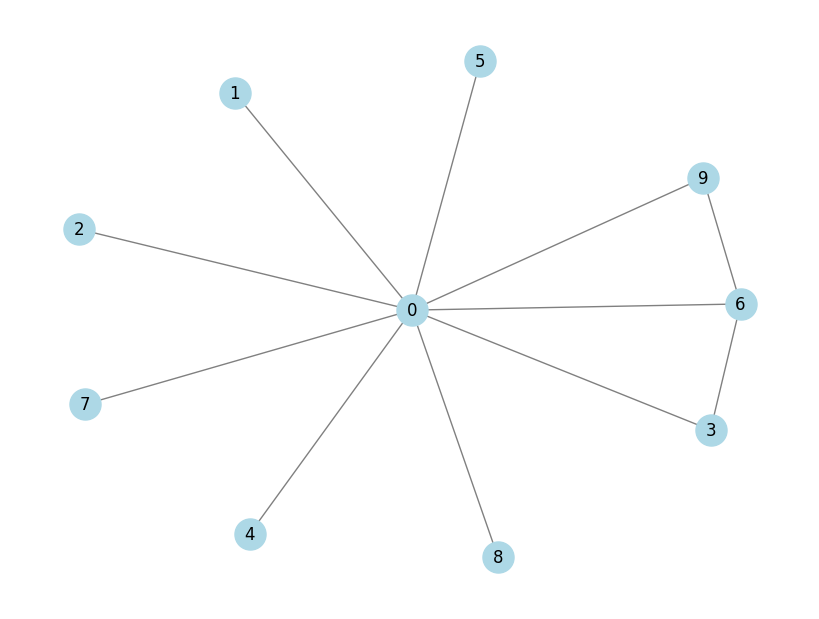

Number of odd cycles in the graph: 2


In [17]:
# Evaluate the model
model = PPO.load("odd_cycle_graph_model")
obs = env.reset()
done = False
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)

# Render the final graph
env.render()

# Count the number of odd cycles in the graph
num_odd_cycles = env.count_odd_cycles(env.G)
print(f"Number of odd cycles in the graph: {num_odd_cycles}")


This graph atisfies the odd cycle condition but it forms a tree like structure.

In [18]:
class OddCycleGraphEnv(gym.Env):
    def __init__(self, n_nodes):
        super(OddCycleGraphEnv, self).__init__()
        self.n_nodes = n_nodes
        self.target_edges = n_nodes * (n_nodes - 1) // 4  # Approximately half of the total possible edges
        self.action_space = spaces.Discrete(n_nodes * n_nodes)  # Add/Remove edges
        self.observation_space = spaces.Box(low=0, high=1, shape=(n_nodes, n_nodes), dtype=np.float32)
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.G = nx.Graph()
        self.G.add_nodes_from(range(self.n_nodes))
        # Initialize the graph using the sequential addition method to ensure it's connected
        self._initialize_connected_graph()
        return nx.to_numpy_array(self.G), {}

    def _initialize_connected_graph(self):
        # Start with a single node
        nodes = list(range(self.n_nodes))
        self.G.add_node(nodes.pop(0))
        while nodes:
            new_node = nodes.pop(0)
            existing_node = np.random.choice(list(self.G.nodes))
            self.G.add_edge(existing_node, new_node)

    def step(self, action):
        i, j = divmod(action, self.n_nodes)
        if self.G.has_edge(i, j):
            self.G.remove_edge(i, j)
            reward = -1
        else:
            self.G.add_edge(i, j)
            reward = 1

        # Encourage the formation of odd cycles
        num_odd_cycles = self.count_odd_cycles(self.G)
        if num_odd_cycles >= 2:
            reward += num_odd_cycles * 10  # Strongly reward having at least two odd cycles

        # Ensure the number of edges is approximately equal to the number of non-edges
        if len(self.G.edges) > self.target_edges:
            reward -= 5

        done = self.check_done(num_odd_cycles)
        obs = nx.to_numpy_array(self.G)
        return obs, reward, done, {}, {}

    def check_done(self, num_odd_cycles):
        # Check if the number of odd cycles is at least 2
        return num_odd_cycles >= 2

    def bfs_check_odd_cycle(self, start):
        visited = {start: 0}
        queue = [(start, 0)]
        while queue:
            current_node, depth = queue.pop(0)
            for neighbor in self.G.neighbors(current_node):
                if neighbor not in visited:
                    visited[neighbor] = depth + 1
                    queue.append((neighbor, depth + 1))
                elif visited[neighbor] % 2 == depth % 2:
                    return True
        return False

    def count_odd_cycles(self, G):
        odd_cycles = []

        # Find all cycles in the graph
        cycles = list(nx.cycle_basis(G))

        # Filter out the odd cycles
        for cycle in cycles:
            if len(cycle) % 2 == 1:
                odd_cycles.append(cycle)

        return len(odd_cycles)

    def render(self, mode='human'):
        plt.figure(figsize=(8, 6))
        np.random.seed(42)  # Set the seed for reproducibility
        pos = {i: np.random.rand(2) for i in range(self.n_nodes)}
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
        plt.show()


In [19]:
# Create and train the model
env = OddCycleGraphEnv(n_nodes=15)  # Example with 10 nodes
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)
model.save("odd_cycle_graph_model")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.3      |
|    ep_rew_mean     | 24.3     |
| time/              |          |
|    fps             | 706      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.2         |
|    ep_rew_mean          | 24.4        |
| time/                   |             |
|    fps                  | 516         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005766887 |
|    clip_fraction        | 0.0173      |
|    clip_range           | 0.2         |
|    entropy_loss   

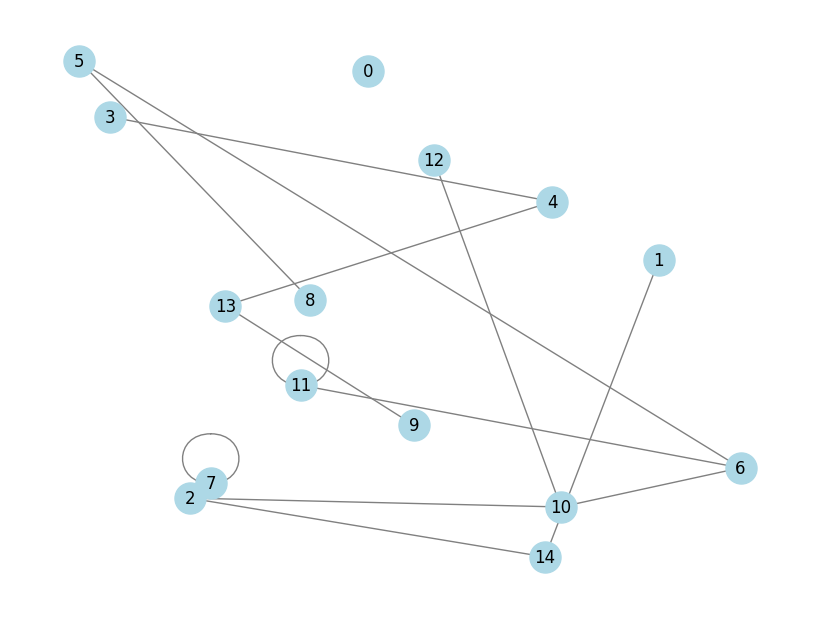

Number of odd cycles in the graph: 2


In [20]:
# Evaluate the model
model = PPO.load("odd_cycle_graph_model")
obs, _ = env.reset()
done = False
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, _, _ = env.step(action)

# Render the final graph
env.render()

# Count the number of odd cycles in the graph
num_odd_cycles = env.count_odd_cycles(env.G)
print(f"Number of odd cycles in the graph: {num_odd_cycles}")


THe graph undergoes self loop and also has isolated vertice. Controlling the model to get optimal results.
Trying to reward more for odd cycle with more vertices and make it present more odd cycles in the graph

In [21]:
# give more reward for odd cycle with more vertices and make it more odd cycles in the graph

In [22]:
class OddCycleGraphEnv(gym.Env):
    def __init__(self, n_nodes):
        super(OddCycleGraphEnv, self).__init__()
        self.n_nodes = n_nodes
        self.action_space = spaces.Discrete(n_nodes * n_nodes)  # Add/Remove edges
        self.observation_space = spaces.Box(low=0, high=1, shape=(n_nodes, n_nodes), dtype=np.float32)
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.G = nx.Graph()
        self.G.add_nodes_from(range(self.n_nodes))
        # Initialize the graph using the sequential addition method to ensure it's connected
        self._initialize_connected_graph()
        return nx.to_numpy_array(self.G), {}

    def _initialize_connected_graph(self):
        # Start with a single node
        nodes = list(range(self.n_nodes))
        self.G.add_node(nodes.pop(0))
        while nodes:
            new_node = nodes.pop(0)
            existing_node = np.random.choice(list(self.G.nodes))
            self.G.add_edge(existing_node, new_node)

    def step(self, action):
        i, j = divmod(action, self.n_nodes)
        if self.G.has_edge(i, j):
            self.G.remove_edge(i, j)
            reward = -1
        else:
            self.G.add_edge(i, j)
            reward = 1

        # Encourage the formation of odd cycles with more vertices
        num_odd_cycles, total_odd_cycle_length = self.count_odd_cycles(self.G)
        reward += num_odd_cycles * 10 + total_odd_cycle_length * 5  # Reward based on the number and length of odd cycles

        done = self.check_done(num_odd_cycles)
        obs = nx.to_numpy_array(self.G)
        return obs, reward, done, {}, {}

    def check_done(self, num_odd_cycles):
        # Check if the number of odd cycles is at least 2
        return num_odd_cycles >= 2

    def bfs_check_odd_cycle(self, start):
        visited = {start: 0}
        queue = [(start, 0)]
        while queue:
            current_node, depth = queue.pop(0)
            for neighbor in self.G.neighbors(current_node):
                if neighbor not in visited:
                    visited[neighbor] = depth + 1
                    queue.append((neighbor, depth + 1))
                elif visited[neighbor] % 2 == depth % 2:
                    return True
        return False

    def count_odd_cycles(self, G):
        odd_cycles = []
        total_length = 0

        # Find all cycles in the graph
        cycles = list(nx.cycle_basis(G))

        # Filter out the odd cycles
        for cycle in cycles:
            if len(cycle) % 2 == 1:
                odd_cycles.append(cycle)
                total_length += len(cycle)

        return len(odd_cycles), total_length

    def render(self, mode='human'):
        plt.figure(figsize=(8, 6))
        np.random.seed(42)  # Set the seed for reproducibility
        pos = {i: np.random.rand(2) for i in range(self.n_nodes)}
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
        plt.show()


In [23]:
# Create and train the model
env = OddCycleGraphEnv(n_nodes=15)  # Example with 10 nodes
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)
model.save("odd_cycle_graph_model")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.25     |
|    ep_rew_mean     | 79.8     |
| time/              |          |
|    fps             | 708      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.45         |
|    ep_rew_mean          | 78.8         |
| time/                   |              |
|    fps                  | 551          |
|    iterations           | 2            |
|    time_elapsed         | 7            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0017774152 |
|    clip_fraction        | 0.00083      |
|    clip_range           | 0.2          |
|    en

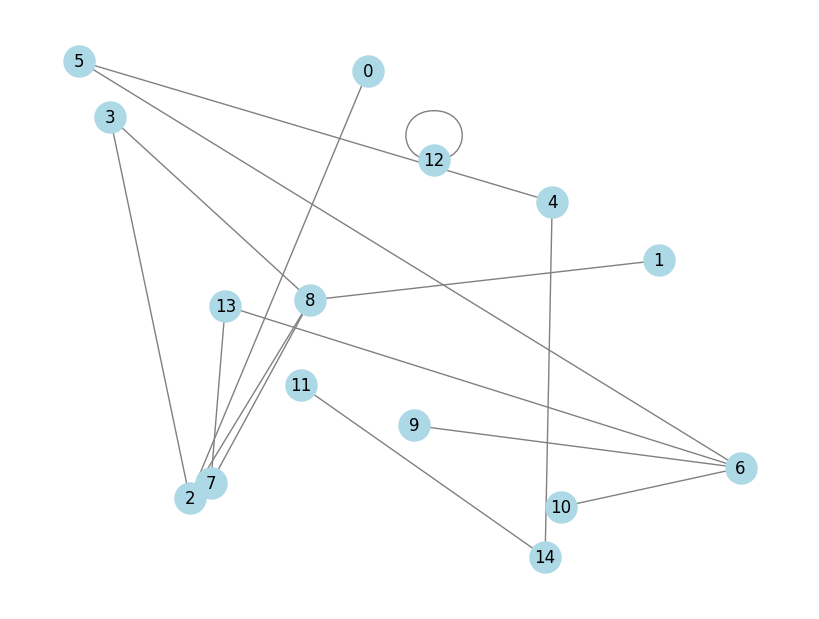

Number of odd cycles in the graph: 2
Total length of odd cycles in the graph: 4


In [24]:
# Evaluate the model
model = PPO.load("odd_cycle_graph_model")
obs, _ = env.reset()
done = False
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, _, _ = env.step(action)

# Render the final graph
env.render()

# Count the number of odd cycles in the graph
num_odd_cycles, total_odd_cycle_length = env.count_odd_cycles(env.G)
print(f"Number of odd cycles in the graph: {num_odd_cycles}")
print(f"Total length of odd cycles in the graph: {total_odd_cycle_length}")


The graph almost satifies the optimal condition. Now we try to highlight the odd cycle in the graph.

In [25]:
class OddCycleGraphEnv(gym.Env):
    def __init__(self, n_nodes):
        super(OddCycleGraphEnv, self).__init__()
        self.n_nodes = n_nodes
        self.action_space = spaces.Discrete(n_nodes * n_nodes)  # Add/Remove edges
        self.observation_space = spaces.Box(low=0, high=1, shape=(n_nodes, n_nodes), dtype=np.float32)
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.G = nx.Graph()
        self.G.add_nodes_from(range(self.n_nodes))
        # Initialize the graph using the sequential addition method to ensure it's connected
        self._initialize_connected_graph()
        return nx.to_numpy_array(self.G, dtype=np.float32), {}

    def _initialize_connected_graph(self):
        # Start with a single node
        nodes = list(range(self.n_nodes))
        self.G.add_node(nodes.pop(0))
        while nodes:
            new_node = nodes.pop(0)
            existing_node = np.random.choice(list(self.G.nodes))
            self.G.add_edge(existing_node, new_node)

    def step(self, action):
        i, j = divmod(action, self.n_nodes)
        if self.G.has_edge(i, j):
            self.G.remove_edge(i, j)
            reward = -1
        else:
            self.G.add_edge(i, j)
            reward = 1

        # Encourage the formation of odd cycles with more vertices
        num_odd_cycles, total_odd_cycle_length = self.count_odd_cycles(self.G)
        reward += num_odd_cycles * 10 + total_odd_cycle_length * 5  # Reward based on the number and length of odd cycles

        done = self.check_done(num_odd_cycles)
        obs = nx.to_numpy_array(self.G, dtype=np.float32)
        return obs, reward, done, {}, {}

    def check_done(self, num_odd_cycles):
        # Check if the number of odd cycles is at least 2
        return num_odd_cycles >= 2

    def bfs_check_odd_cycle(self, start):
        visited = {start: 0}
        queue = [(start, 0)]
        while queue:
            current_node, depth = queue.pop(0)
            for neighbor in self.G.neighbors(current_node):
                if neighbor not in visited:
                    visited[neighbor] = depth + 1
                    queue.append((neighbor, depth + 1))
                elif visited[neighbor] % 2 == depth % 2:
                    return True
        return False

    def count_odd_cycles(self, G):
        odd_cycles = []
        total_length = 0

        # Find all cycles in the graph
        cycles = list(nx.cycle_basis(G))

        # Filter out the odd cycles
        for cycle in cycles:
            if len(cycle) % 2 == 1:
                odd_cycles.append(cycle)
                total_length += len(cycle)

        return len(odd_cycles), total_length

    def render(self, mode='human'):
        plt.figure(figsize=(8, 6))
        np.random.seed(42)  # Set the seed for reproducibility
        pos = {i: np.random.rand(2) for i in range(self.n_nodes)}

        # Draw the graph
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)

        # Highlight odd cycles
        odd_cycles = [cycle for cycle in nx.cycle_basis(self.G) if len(cycle) % 2 == 1]
        for cycle in odd_cycles:
            cycle_edges = [(cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle))]
            nx.draw_networkx_edges(self.G, pos, edgelist=cycle_edges, edge_color='red', width=2)

        plt.show()


In [26]:
# Create and train the model
n_nodes = 15
env = OddCycleGraphEnv(n_nodes=n_nodes)  # Example with 10 nodes
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)
model.save("odd_cycle_graph_model")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.49     |
|    ep_rew_mean     | 81       |
| time/              |          |
|    fps             | 697      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.37         |
|    ep_rew_mean          | 77.8         |
| time/                   |              |
|    fps                  | 551          |
|    iterations           | 2            |
|    time_elapsed         | 7            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0014202035 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    en

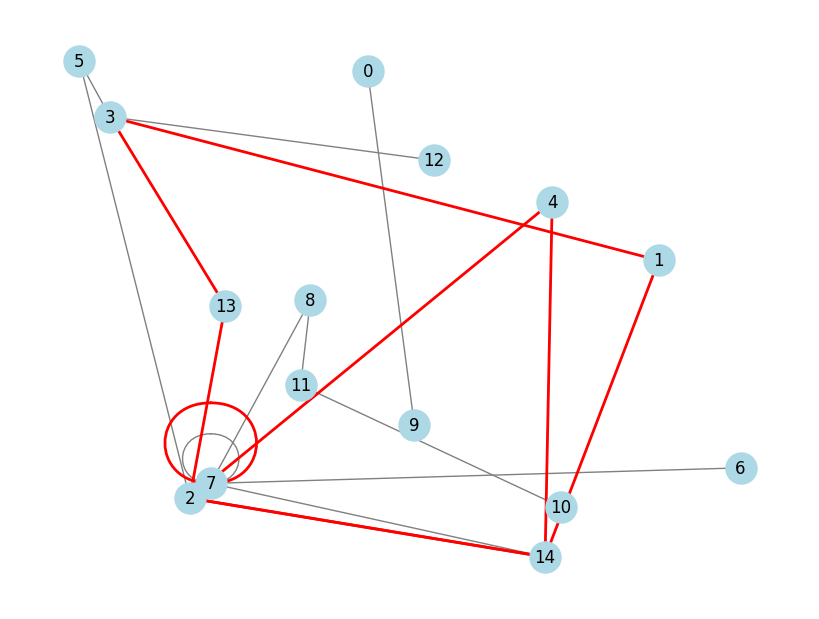

Number of odd cycles in the graph: 3
Total length of odd cycles in the graph: 9


In [27]:
# Evaluate the model
model = PPO.load("odd_cycle_graph_model")
obs, _ = env.reset()
done = False
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, _, _ = env.step(action)

# Render the final graph
env.render()

# Count the number of odd cycles in the graph
num_odd_cycles, total_odd_cycle_length = env.count_odd_cycles(env.G)
print(f"Number of odd cycles in the graph: {num_odd_cycles}")
print(f"Total length of odd cycles in the graph: {total_odd_cycle_length}")


It highlights the odd cycle in the graph but not all the odd cycles present in graph. So trying to highlight all odd cycles

In [28]:
class OddCycleGraphEnv(gym.Env):
    def __init__(self, n_nodes):
        super(OddCycleGraphEnv, self).__init__()
        self.n_nodes = n_nodes
        self.action_space = spaces.Discrete(n_nodes * n_nodes)  # Add/Remove edges
        self.observation_space = spaces.Box(low=0, high=1, shape=(n_nodes, n_nodes), dtype=np.float32)
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.G = nx.Graph()
        self.G.add_nodes_from(range(self.n_nodes))
        # Initialize the graph using the sequential addition method to ensure it's connected
        self._initialize_connected_graph()
        return nx.to_numpy_array(self.G, dtype=np.float32), {}

    def _initialize_connected_graph(self):
        # Start with a single node
        nodes = list(range(self.n_nodes))
        self.G.add_node(nodes.pop(0))
        while nodes:
            new_node = nodes.pop(0)
            existing_node = np.random.choice(list(self.G.nodes))
            self.G.add_edge(existing_node, new_node)

    def step(self, action):
        i, j = divmod(action, self.n_nodes)
        if self.G.has_edge(i, j):
            self.G.remove_edge(i, j)
            reward = -1
        else:
            self.G.add_edge(i, j)
            reward = 1

        # Encourage the formation of odd cycles with more vertices
        num_odd_cycles, total_odd_cycle_length = self.count_odd_cycles(self.G)
        reward += num_odd_cycles * 10 + total_odd_cycle_length * 5  # Reward based on the number and length of odd cycles

        done = self.check_done(num_odd_cycles)
        obs = nx.to_numpy_array(self.G, dtype=np.float32)
        return obs, reward, done, {}, {}

    def check_done(self, num_odd_cycles):
        # Check if the number of odd cycles is at least 2
        return num_odd_cycles >= 2

    def bfs_check_odd_cycle(self, start):
        visited = {start: 0}
        queue = [(start, 0)]
        while queue:
            current_node, depth = queue.pop(0)
            for neighbor in self.G.neighbors(current_node):
                if neighbor not in visited:
                    visited[neighbor] = depth + 1
                    queue.append((neighbor, depth + 1))
                elif visited[neighbor] % 2 == depth % 2:
                    return True
        return False

    def count_odd_cycles(self, G):
        odd_cycles = []
        total_length = 0

        # Find all cycles in the graph
        cycles = list(nx.cycle_basis(G))

        # Filter out the odd cycles
        for cycle in cycles:
            if len(cycle) % 2 == 1:
                odd_cycles.append(cycle)
                total_length += len(cycle)

        return len(odd_cycles), total_length

    def render(self, mode='human'):
        plt.figure(figsize=(8, 6))
        np.random.seed(42)  # Set the seed for reproducibility
        pos = {i: np.random.rand(2) for i in range(self.n_nodes)}

        # Draw the graph
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)

        # Highlight odd cycles
        odd_cycles = [cycle for cycle in nx.cycle_basis(self.G) if len(cycle) % 2 == 1]
        for cycle in odd_cycles:
            cycle_edges = [(cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle))]
            nx.draw_networkx_edges(self.G, pos, edgelist=cycle_edges, edge_color='red', width=2)

        plt.show()


In [29]:
# Create and train the model
n_nodes = 10  # Example with 15 nodes
env = OddCycleGraphEnv(n_nodes=n_nodes)
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)
model.save("odd_cycle_graph_model")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.23     |
|    ep_rew_mean     | 78.1     |
| time/              |          |
|    fps             | 568      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.89         |
|    ep_rew_mean          | 81.4         |
| time/                   |              |
|    fps                  | 538          |
|    iterations           | 2            |
|    time_elapsed         | 7            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0029344177 |
|    clip_fraction        | 0.00127      |
|    clip_range           | 0.2          |
|    en

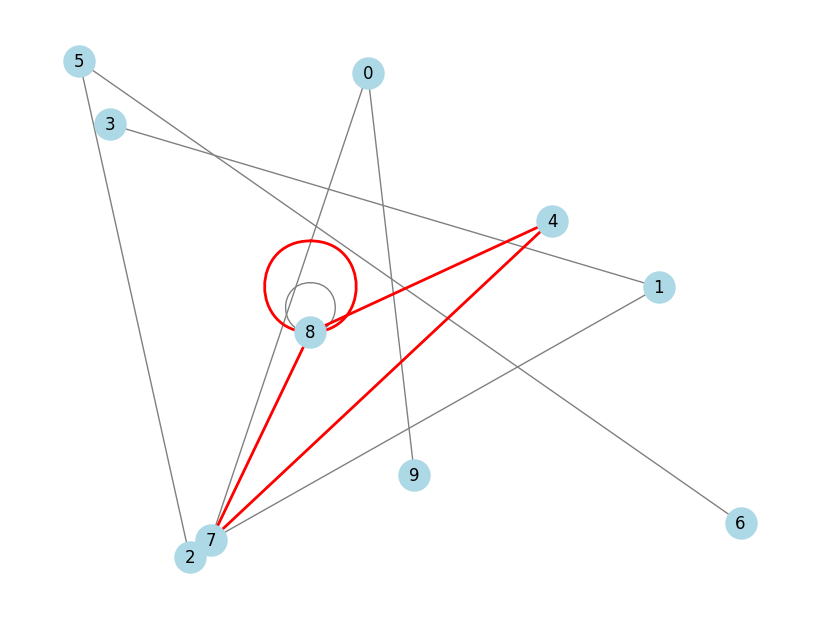

Number of odd cycles in the graph: 2
Total length of odd cycles in the graph: 4


In [30]:
# Evaluate the model
model = PPO.load("odd_cycle_graph_model")
obs, _ = env.reset()
done = False
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, _, _ = env.step(action)

# Render the final graph
env.render()

# Count the number of odd cycles in the graph
num_odd_cycles, total_odd_cycle_length = env.count_odd_cycles(env.G)
print(f"Number of odd cycles in the graph: {num_odd_cycles}")
print(f"Total length of odd cycles in the graph: {total_odd_cycle_length}")


Above method is able to highlight all odd cycles in graph and also find the total length of odd cycles in the graph.
Next step is to mention the cycle length of individual odd cycle.

There are still idle vertices

mention number of vertices in each odd cycle
not the combined total

and try to create more odd cycles in graph and make it clearly visible

In [31]:
class OddCycleGraphEnv(gym.Env):
    def __init__(self, n_nodes):
        super(OddCycleGraphEnv, self).__init__()
        self.n_nodes = n_nodes
        self.action_space = spaces.Discrete(n_nodes * n_nodes)  # Add/Remove edges
        self.observation_space = spaces.Box(low=0, high=1, shape=(n_nodes, n_nodes), dtype=np.float32)
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.G = nx.Graph()
        self.G.add_nodes_from(range(self.n_nodes))
        # Initialize the graph using the sequential addition method to ensure it's connected
        self._initialize_connected_graph()
        return nx.to_numpy_array(self.G, dtype=np.float32), {}

    def _initialize_connected_graph(self):
        # Start with a single node
        nodes = list(range(self.n_nodes))
        self.G.add_node(nodes.pop(0))
        while nodes:
            new_node = nodes.pop(0)
            existing_node = np.random.choice(list(self.G.nodes))
            self.G.add_edge(existing_node, new_node)

    def step(self, action):
        i, j = divmod(action, self.n_nodes)
        if self.G.has_edge(i, j):
            self.G.remove_edge(i, j)
            reward = -1
        else:
            self.G.add_edge(i, j)
            reward = 1

        # Encourage the formation of odd cycles with more vertices
        odd_cycles = self.get_odd_cycles(self.G)
        num_odd_cycles = len(odd_cycles)
        total_odd_cycle_length = sum(len(cycle) for cycle in odd_cycles)
        reward += num_odd_cycles * 10 + total_odd_cycle_length * 5  # Reward based on the number and length of odd cycles

        done = self.check_done(num_odd_cycles)
        obs = nx.to_numpy_array(self.G, dtype=np.float32)
        return obs, reward, done, {}, {}

    def check_done(self, num_odd_cycles):
        # Check if the number of odd cycles is at least 3 for better results
        return num_odd_cycles >= 3

    def get_odd_cycles(self, G):
        odd_cycles = []
        # Find all cycles in the graph
        cycles = list(nx.cycle_basis(G))
        # Filter out the odd cycles
        for cycle in cycles:
            if len(cycle) % 2 == 1:
                odd_cycles.append(cycle)
        return odd_cycles

    def render(self, mode='human'):
        plt.figure(figsize=(8, 6))
        np.random.seed(42)  # Set the seed for reproducibility
        pos = {i: np.random.rand(2) for i in range(self.n_nodes)}

        # Draw the graph
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)

        # Highlight odd cycles
        odd_cycles = self.get_odd_cycles(self.G)
        for cycle in odd_cycles:
            cycle_edges = [(cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle))]
            nx.draw_networkx_edges(self.G, pos, edgelist=cycle_edges, edge_color='red', width=2)

        # Display the number of vertices in each odd cycle
        cycle_lengths = [len(cycle) for cycle in odd_cycles]
        plt.title(f"Number of odd cycles: {len(odd_cycles)}\nLengths of odd cycles: {cycle_lengths}")

        plt.show()


In [32]:
# Create and train the model
n_nodes = 15  # Example with 15 nodes
env = OddCycleGraphEnv(n_nodes=n_nodes)
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=20000)
model.save("odd_cycle_graph_model")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.37     |
|    ep_rew_mean     | 189      |
| time/              |          |
|    fps             | 783      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 4.69          |
|    ep_rew_mean          | 204           |
| time/                   |               |
|    fps                  | 518           |
|    iterations           | 2             |
|    time_elapsed         | 7             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00047901005 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2       

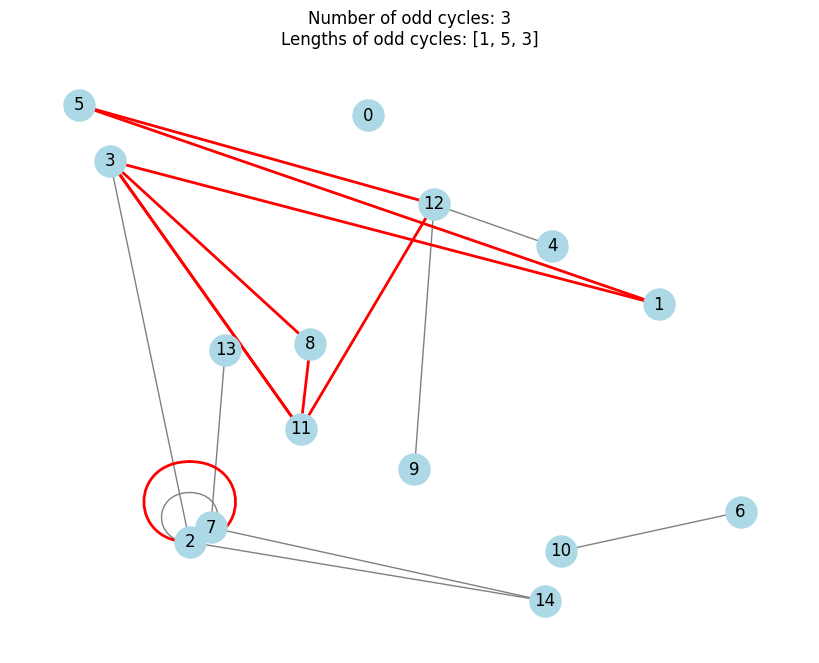

Number of odd cycles in the graph: 3
Lengths of odd cycles in the graph: [1, 5, 3]


In [33]:
# Evaluate the model
model = PPO.load("odd_cycle_graph_model")
obs, _ = env.reset()
done = False
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, _, _ = env.step(action)

# Render the final graph
env.render()

# Count the number of odd cycles in the graph
odd_cycles = env.get_odd_cycles(env.G)
num_odd_cycles = len(odd_cycles)
cycle_lengths = [len(cycle) for cycle in odd_cycles]
print(f"Number of odd cycles in the graph: {num_odd_cycles}")
print(f"Lengths of odd cycles in the graph: {cycle_lengths}")


This graph has able to mention the length of the cycle and also highlight all the odd cycle. To increase more understanding of graph, the graph is assign different colors for each odd cycle and along with the length mention the cycle path

In [34]:
class OddCycleGraphEnv(gym.Env):
    def __init__(self, n_nodes):
        super(OddCycleGraphEnv, self).__init__()
        self.n_nodes = n_nodes
        self.action_space = spaces.Discrete(n_nodes * n_nodes)  # Add/Remove edges
        self.observation_space = spaces.Box(low=0, high=1, shape=(n_nodes, n_nodes), dtype=np.float32)
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.G = nx.Graph()
        self.G.add_nodes_from(range(self.n_nodes))
        # Initialize the graph using the sequential addition method to ensure it's connected
        self._initialize_connected_graph()
        return nx.to_numpy_array(self.G, dtype=np.float32), {}

    def _initialize_connected_graph(self):
        # Start with a single node
        nodes = list(range(self.n_nodes))
        self.G.add_node(nodes.pop(0))
        while nodes:
            new_node = nodes.pop(0)
            existing_node = np.random.choice(list(self.G.nodes))
            self.G.add_edge(existing_node, new_node)

    def step(self, action):
        i, j = divmod(action, self.n_nodes)
        if self.G.has_edge(i, j):
            self.G.remove_edge(i, j)
            reward = -1
        else:
            self.G.add_edge(i, j)
            reward = 1

        # Encourage the formation of odd cycles with more vertices
        odd_cycles = self.get_odd_cycles(self.G)
        num_odd_cycles = len(odd_cycles)
        total_odd_cycle_length = sum(len(cycle) for cycle in odd_cycles)
        reward += num_odd_cycles * 10 + total_odd_cycle_length * 5  # Reward based on the number and length of odd cycles

        done = self.check_done(num_odd_cycles)
        obs = nx.to_numpy_array(self.G, dtype=np.float32)
        return obs, reward, done, {}, {}

    def check_done(self, num_odd_cycles):
        # Check if the number of odd cycles is at least 3 for better results
        return num_odd_cycles >= 3

    def get_odd_cycles(self, G):
        odd_cycles = []
        # Find all cycles in the graph
        cycles = list(nx.cycle_basis(G))
        # Filter out the odd cycles
        for cycle in cycles:
            if len(cycle) % 2 == 1:
                odd_cycles.append(cycle)
        return odd_cycles

    def render(self, mode='human'):
        plt.figure(figsize=(8, 6))
        np.random.seed(42)  # Set the seed for reproducibility
        pos = {i: np.random.rand(2) for i in range(self.n_nodes)}

        # Draw the graph
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)

        # Highlight odd cycles with different colors
        odd_cycles = self.get_odd_cycles(self.G)
        colors = list(mcolors.CSS4_COLORS.values())
        random.shuffle(colors)
        cycle_info = []

        for idx, cycle in enumerate(odd_cycles):
            cycle_edges = [(cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle))]
            color = colors[idx % len(colors)]
            nx.draw_networkx_edges(self.G, pos, edgelist=cycle_edges, edge_color=color, width=2)
            cycle_info.append((len(cycle), cycle))

        # Display the number of vertices and paths in each odd cycle
        cycle_lengths = [f"Length {info[0]}: {info[1]}" for info in cycle_info]
        plt.title(f"Number of odd cycles: {len(odd_cycles)}\nCycle Info: {cycle_lengths}")

        plt.show()


In [35]:
# Create and train the model
n_nodes = 15  # Example with 15 nodes
env = OddCycleGraphEnv(n_nodes=n_nodes)
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=20000)
model.save("odd_cycle_graph_model")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.96     |
|    ep_rew_mean     | 214      |
| time/              |          |
|    fps             | 684      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 4.1           |
|    ep_rew_mean          | 177           |
| time/                   |               |
|    fps                  | 572           |
|    iterations           | 2             |
|    time_elapsed         | 7             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00045017077 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2       

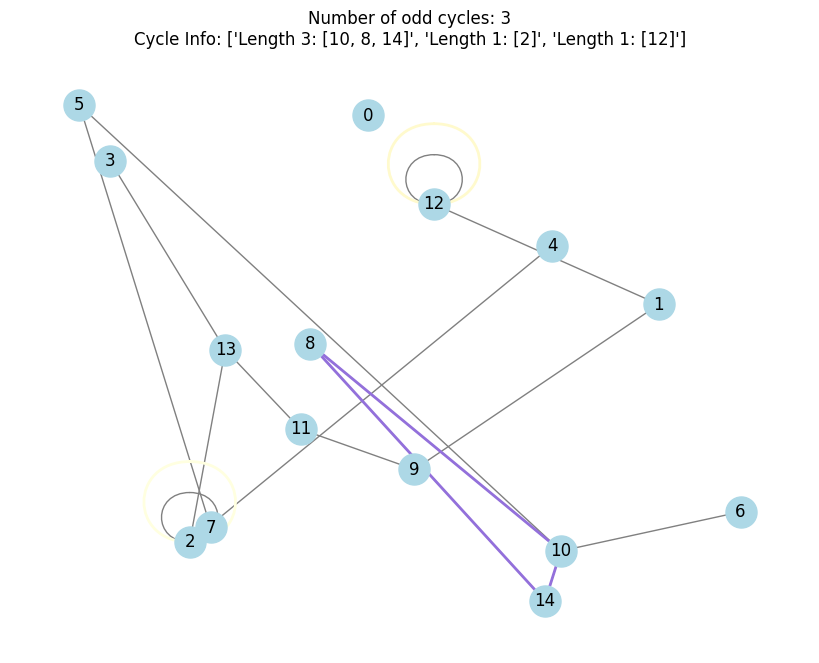

Number of odd cycles in the graph: 3
Cycle Info: ['Length 3: [10, 8, 14]', 'Length 1: [2]', 'Length 1: [12]']


In [36]:
# Evaluate the model
model = PPO.load("odd_cycle_graph_model")
obs, _ = env.reset()
done = False
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, _, _ = env.step(action)

# Render the final graph
env.render()

# Count the number of odd cycles in the graph
odd_cycles = env.get_odd_cycles(env.G)
num_odd_cycles = len(odd_cycles)
cycle_info = [(len(cycle), cycle) for cycle in odd_cycles]
cycle_lengths = [f"Length {info[0]}: {info[1]}" for info in cycle_info]
print(f"Number of odd cycles in the graph: {num_odd_cycles}")
print(f"Cycle Info: {cycle_lengths}")


In [37]:
class OddCycleGraphEnv(gym.Env):
    def __init__(self, n_nodes):
        super(OddCycleGraphEnv, self).__init__()
        self.n_nodes = n_nodes
        self.action_space = spaces.Discrete(n_nodes * n_nodes)  # Add/Remove edges
        self.observation_space = spaces.Box(low=0, high=1, shape=(n_nodes, n_nodes), dtype=np.float32)
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.G = nx.Graph()
        self.G.add_nodes_from(range(self.n_nodes))
        # Initialize the graph using the sequential addition method to ensure it's connected
        self._initialize_connected_graph()
        return nx.to_numpy_array(self.G, dtype=np.float32), {}

    def _initialize_connected_graph(self):
        # Start with a single node
        nodes = list(range(self.n_nodes))
        self.G.add_node(nodes.pop(0))
        while nodes:
            new_node = nodes.pop(0)
            existing_node = np.random.choice(list(self.G.nodes))
            self.G.add_edge(existing_node, new_node)

    def step(self, action):
        i, j = divmod(action, self.n_nodes)
        if self.G.has_edge(i, j):
            self.G.remove_edge(i, j)
            reward = -1
        else:
            self.G.add_edge(i, j)
            reward = 1

        # Encourage the formation of odd cycles with more vertices
        odd_cycles = self.get_odd_cycles(self.G)
        num_odd_cycles = len(odd_cycles)
        total_odd_cycle_length = sum(len(cycle) for cycle in odd_cycles)
        reward += num_odd_cycles * 10 + total_odd_cycle_length * 5  # Reward based on the number and length of odd cycles

        done = self.check_done(num_odd_cycles)
        obs = nx.to_numpy_array(self.G, dtype=np.float32)
        return obs, reward, done, {}, {}

    def check_done(self, num_odd_cycles):
        # Check if the number of odd cycles is at least 3 for better results
        return num_odd_cycles >= 3

    def get_odd_cycles(self, G):
        odd_cycles = []
        # Find all cycles in the graph
        cycles = list(nx.cycle_basis(G))
        # Filter out the odd cycles
        for cycle in cycles:
            if len(cycle) % 2 == 1:
                odd_cycles.append(cycle)
        return odd_cycles

    def render(self, mode='human'):
        plt.figure(figsize=(8, 6))
        np.random.seed(42)  # Set the seed for reproducibility
        pos = {i: np.random.rand(2) for i in range(self.n_nodes)}

        # Draw the graph
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)

        # Highlight odd cycles with different colors
        odd_cycles = self.get_odd_cycles(self.G)
        colors = list(mcolors.TABLEAU_COLORS.values())
        random.shuffle(colors)
        cycle_info = []

        for idx, cycle in enumerate(odd_cycles):
            cycle_edges = [(cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle))]
            color = colors[idx % len(colors)]
            nx.draw_networkx_edges(self.G, pos, edgelist=cycle_edges, edge_color=color, width=2)
            cycle_info.append((len(cycle), cycle + [cycle[0]]))  # Include start and end vertices

        # Display the number of vertices and paths in each odd cycle
        cycle_lengths = [f"Length {info[0]}: {info[1]}" for info in cycle_info]
        plt.title(f"Number of odd cycles: {len(odd_cycles)}\nCycle Info: {cycle_lengths}")

        plt.show()


In [38]:
# Create and train the model
n_nodes = 10  # Example with 15 nodes
env = OddCycleGraphEnv(n_nodes=n_nodes)
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=20000)
model.save("odd_cycle_graph_model")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.73     |
|    ep_rew_mean     | 209      |
| time/              |          |
|    fps             | 866      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 5.1          |
|    ep_rew_mean          | 197          |
| time/                   |              |
|    fps                  | 645          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0014936976 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    en

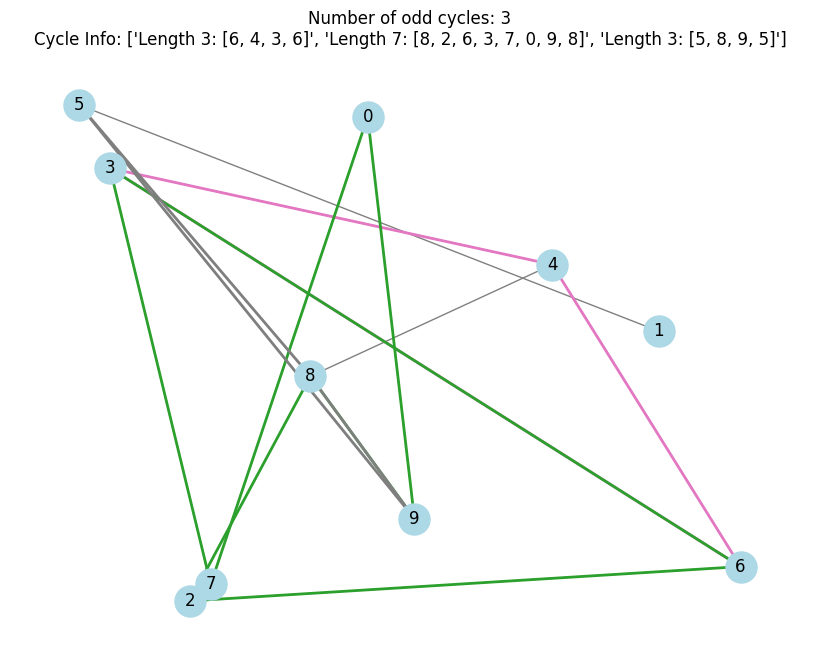

In [39]:
# Evaluate the model
model = PPO.load("odd_cycle_graph_model")
obs, _ = env.reset()
done = False
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, _, _ = env.step(action)

# Render the final graph
env.render()

# Count the number of odd cycles in the graph
odd_cycles = env.get_odd_cycles(env.G)
num_odd_cycles = len(odd_cycles)
cycle_info = [(len(cycle), cycle + [cycle[0]]) for cycle in odd_cycles]
cycle_lengths = [f"Length {info[0]}: {info[1]}" for info in cycle_info]
#print(f"Number of odd cycles in the graph: {num_odd_cycles}")
#print(f"Cycle Info: {cycle_lengths}")


The model is considering odd cycles with 1 verties also, making it to have minimum 3 vertices for the best result and also trying to reward more if the odd cycle have more vertices.

In [40]:
class OddCycleGraphEnv(gym.Env):
    def __init__(self, n_nodes):
        super(OddCycleGraphEnv, self).__init__()
        self.n_nodes = n_nodes
        self.action_space = spaces.Discrete(n_nodes * n_nodes)  # Add/Remove edges
        self.observation_space = spaces.Box(low=0, high=1, shape=(n_nodes, n_nodes), dtype=np.float32)
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.G = nx.Graph()
        self.G.add_nodes_from(range(self.n_nodes))
        # Initialize the graph using the sequential addition method to ensure it's connected
        self._initialize_connected_graph()
        return nx.to_numpy_array(self.G, dtype=np.float32), {}

    def _initialize_connected_graph(self):
        # Start with a single node
        nodes = list(range(self.n_nodes))
        self.G.add_node(nodes.pop(0))
        while nodes:
            new_node = nodes.pop(0)
            existing_node = np.random.choice(list(self.G.nodes))
            self.G.add_edge(existing_node, new_node)

    def step(self, action):
        i, j = divmod(action, self.n_nodes)
        if self.G.has_edge(i, j):
            self.G.remove_edge(i, j)
            reward = -1
        else:
            self.G.add_edge(i, j)
            reward = 1

        # Encourage the formation of odd cycles with more vertices
        odd_cycles = self.get_odd_cycles(self.G)
        num_odd_cycles = len(odd_cycles)
        valid_odd_cycles = [cycle for cycle in odd_cycles if len(cycle) >= 3]
        num_valid_odd_cycles = len(valid_odd_cycles)
        total_odd_cycle_length = sum(len(cycle) for cycle in valid_odd_cycles)
        reward += num_valid_odd_cycles * 10 + total_odd_cycle_length * 5  # Reward based on the number and length of valid odd cycles

        done = self.check_done(num_valid_odd_cycles)
        obs = nx.to_numpy_array(self.G, dtype=np.float32)
        return obs, reward, done, {}, {}

    def check_done(self, num_odd_cycles):
        # Check if the number of valid odd cycles is at least 3 for better results
        return num_odd_cycles >= 3

    def get_odd_cycles(self, G):
        odd_cycles = []
        # Find all cycles in the graph
        cycles = list(nx.cycle_basis(G))
        # Filter out the odd cycles
        for cycle in cycles:
            if len(cycle) % 2 == 1:
                odd_cycles.append(cycle)
        return odd_cycles

    def render(self, mode='human'):
        plt.figure(figsize=(8, 6))
        np.random.seed(42)  # Set the seed for reproducibility
        pos = {i: np.random.rand(2) for i in range(self.n_nodes)}

        # Draw the graph
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)

        # Highlight odd cycles with different colors
        odd_cycles = self.get_odd_cycles(self.G)
        valid_odd_cycles = [cycle for cycle in odd_cycles if len(cycle) >= 3]
        colors = list(mcolors.TABLEAU_COLORS.values())
        random.shuffle(colors)
        cycle_info = []

        for idx, cycle in enumerate(valid_odd_cycles):
            cycle_edges = [(cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle))]
            color = colors[idx % len(colors)]
            nx.draw_networkx_edges(self.G, pos, edgelist=cycle_edges, edge_color=color, width=2)
            cycle_info.append((len(cycle), cycle + [cycle[0]]))  # Include start and end vertices

        # Display the number of vertices and paths in each odd cycle
        cycle_lengths = [f"Length {info[0]}: {info[1]}" for info in cycle_info]
        plt.title(f"Number of odd cycles: {len(valid_odd_cycles)}\nCycle Info: {cycle_lengths}")

        plt.show()


In [41]:
# Create and train the model
n_nodes = 20  # Example with 15 nodes
env = OddCycleGraphEnv(n_nodes=n_nodes)
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=20000)
model.save("odd_cycle_graph_model")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.86     |
|    ep_rew_mean     | 342      |
| time/              |          |
|    fps             | 769      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 7.72          |
|    ep_rew_mean          | 365           |
| time/                   |               |
|    fps                  | 490           |
|    iterations           | 2             |
|    time_elapsed         | 8             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00018592083 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2       

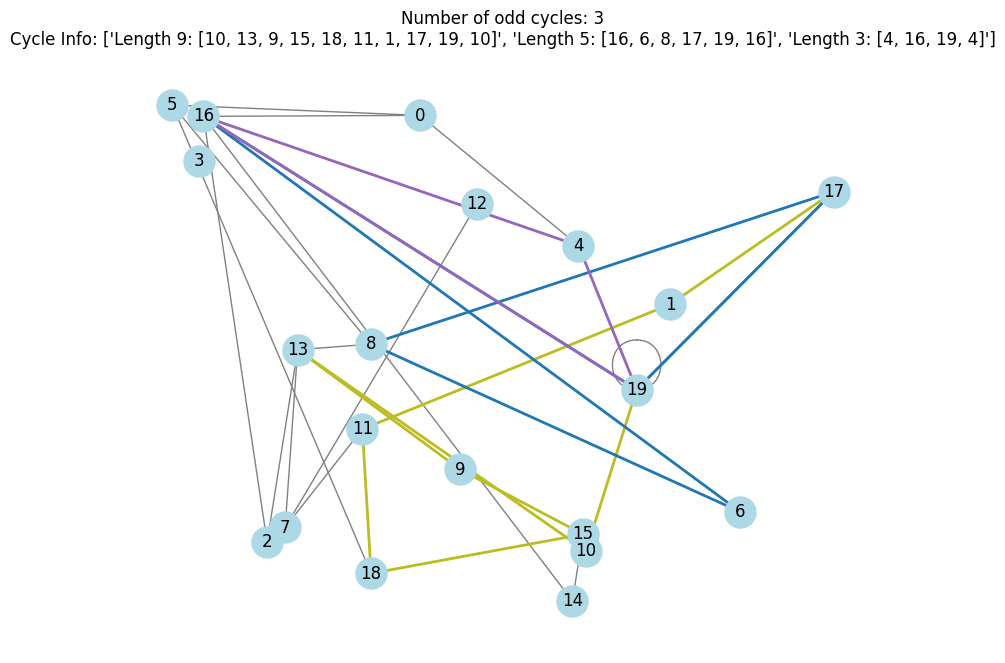

Number of odd cycles in the graph: 3
Cycle Info: ['Length 9: [10, 13, 9, 15, 18, 11, 1, 17, 19, 10]', 'Length 5: [16, 6, 8, 17, 19, 16]', 'Length 3: [4, 16, 19, 4]']


In [42]:
# Evaluate the model
model = PPO.load("odd_cycle_graph_model")
obs, _ = env.reset()
done = False
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, _, _ = env.step(action)

# Render the final graph
env.render()

# Count the number of odd cycles in the graph
odd_cycles = env.get_odd_cycles(env.G)
valid_odd_cycles = [cycle for cycle in odd_cycles if len(cycle) >= 3]
num_valid_odd_cycles = len(valid_odd_cycles)
cycle_info = [(len(cycle), cycle + [cycle[0]]) for cycle in valid_odd_cycles]
cycle_lengths = [f"Length {info[0]}: {info[1]}" for info in cycle_info]
print(f"Number of odd cycles in the graph: {num_valid_odd_cycles}")
print(f"Cycle Info: {cycle_lengths}")


Since, there are still idle vertices in the generated graph trying to make sure vertices is always connected.

In [43]:
class OddCycleGraphEnv(gym.Env):
    def __init__(self, n_nodes):
        super(OddCycleGraphEnv, self).__init__()
        self.n_nodes = n_nodes
        self.action_space = spaces.Discrete(n_nodes * n_nodes)  # Add/Remove edges
        self.observation_space = spaces.Box(low=0, high=1, shape=(n_nodes, n_nodes), dtype=np.float32)
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.G = nx.Graph()
        self.G.add_nodes_from(range(self.n_nodes))
        # Initialize the graph using the sequential addition method to ensure it's connected
        self._initialize_connected_graph()
        return nx.to_numpy_array(self.G, dtype=np.float32), {}

    def _initialize_connected_graph(self):
        # Start with a single node
        nodes = list(range(self.n_nodes))
        self.G.add_node(nodes.pop(0))
        while nodes:
            new_node = nodes.pop(0)
            existing_node = np.random.choice(list(self.G.nodes))
            self.G.add_edge(existing_node, new_node)

    def step(self, action):
        i, j = divmod(action, self.n_nodes)
        if i == j:
            return self._invalid_action()
        if self.G.has_edge(i, j):
            self.G.remove_edge(i, j)
            if not nx.is_connected(self.G):
                self.G.add_edge(i, j)  # Revert the removal to maintain connectivity
                return self._invalid_action()
            reward = -1
        else:
            self.G.add_edge(i, j)
            reward = 1

        # Encourage the formation of odd cycles with more vertices
        odd_cycles = self.get_odd_cycles(self.G)
        num_odd_cycles = len(odd_cycles)
        valid_odd_cycles = [cycle for cycle in odd_cycles if len(cycle) >= 3]
        num_valid_odd_cycles = len(valid_odd_cycles)
        total_odd_cycle_length = sum(len(cycle) for cycle in valid_odd_cycles)
        reward += num_valid_odd_cycles * 10 + total_odd_cycle_length * 5  # Reward based on the number and length of valid odd cycles

        done = self.check_done(num_valid_odd_cycles)
        obs = nx.to_numpy_array(self.G, dtype=np.float32)
        return obs, reward, done, {}, {}

    def _invalid_action(self):
        obs = nx.to_numpy_array(self.G, dtype=np.float32)
        return obs, -10, False, {}, {}

    def check_done(self, num_odd_cycles):
        # Check if the number of valid odd cycles is at least 3 for better results
        return num_odd_cycles >= 3

    def get_odd_cycles(self, G):
        odd_cycles = []
        # Find all cycles in the graph
        cycles = list(nx.cycle_basis(G))
        # Filter out the odd cycles
        for cycle in cycles:
            if len(cycle) % 2 == 1 and len(cycle) >= 3:
                odd_cycles.append(cycle)
        return odd_cycles

    def render(self, mode='human'):
        plt.figure(figsize=(8, 6))
        np.random.seed(42)  # Set the seed for reproducibility
        pos = {i: np.random.rand(2) for i in range(self.n_nodes)}

        # Draw the graph
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)

        # Highlight odd cycles with different colors
        odd_cycles = self.get_odd_cycles(self.G)
        colors = list(mcolors.TABLEAU_COLORS.values())
        random.shuffle(colors)
        cycle_info = []

        for idx, cycle in enumerate(odd_cycles):
            cycle_edges = [(cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle))]
            color = colors[idx % len(colors)]
            nx.draw_networkx_edges(self.G, pos, edgelist=cycle_edges, edge_color=color, width=2)
            cycle_info.append((len(cycle), cycle + [cycle[0]]))  # Include start and end vertices

        # Display the number of vertices and paths in each odd cycle
        cycle_lengths = [f"Length {info[0]}: {info[1]}" for info in cycle_info]
        plt.title(f"Number of odd cycles: {len(odd_cycles)}\nCycle Info: {cycle_lengths}")

        plt.show()


In [44]:
# Create and train the model
n_nodes = 10 # Example with 20 nodes
env = OddCycleGraphEnv(n_nodes=n_nodes)
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=20000)
model.save("odd_cycle_graph_model")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.73     |
|    ep_rew_mean     | 256      |
| time/              |          |
|    fps             | 892      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 9.41         |
|    ep_rew_mean          | 273          |
| time/                   |              |
|    fps                  | 670          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0011237244 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    en

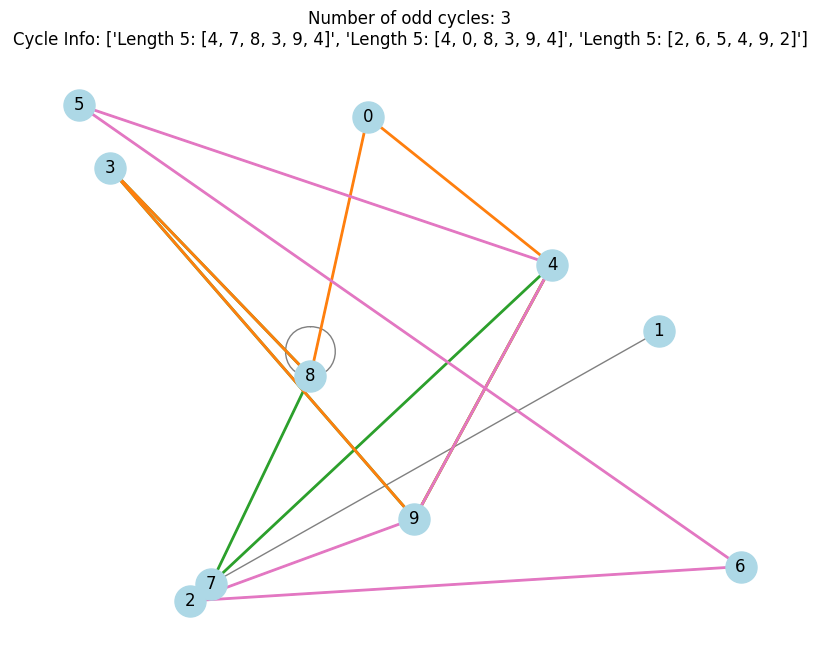

Number of odd cycles in the graph: 3
Cycle Info: ['Length 5: [4, 7, 8, 3, 9, 4]', 'Length 5: [4, 0, 8, 3, 9, 4]', 'Length 5: [2, 6, 5, 4, 9, 2]']


In [45]:
# Evaluate the model
model = PPO.load("odd_cycle_graph_model")
obs, _ = env.reset()
done = False
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, _, _ = env.step(action)

# Render the final graph
env.render()

# Count the number of odd cycles in the graph
odd_cycles = env.get_odd_cycles(env.G)
num_valid_odd_cycles = len(odd_cycles)
cycle_info = [(len(cycle), cycle + [cycle[0]]) for cycle in odd_cycles]
cycle_lengths = [f"Length {info[0]}: {info[1]}" for info in cycle_info]
print(f"Number of odd cycles in the graph: {num_valid_odd_cycles}")
print(f"Cycle Info: {cycle_lengths}")


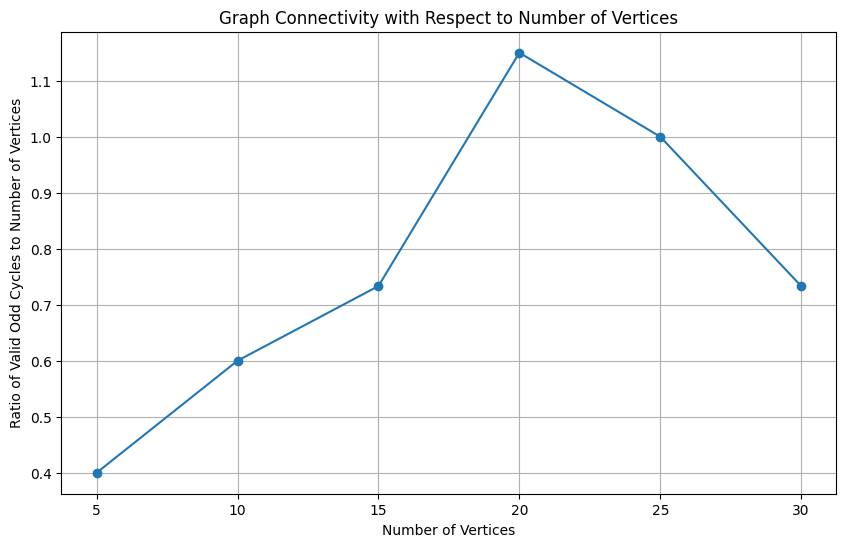

In [46]:
# calculate the ratio of valid odd cycles
ratios = []
vertices = [5, 10, 15, 20,25,30]

for n in vertices:
    env = OddCycleGraphEnv(n_nodes=n)
    obs, _ = env.reset()

    # Simulate adding edges to the graph
    for _ in range(n * 2):
        action = env.action_space.sample()
        obs, reward, done, _, _ = env.step(action)

    # Calculate the ratio of valid odd cycles to the number of vertices
    num_odd_cycles = len(env.get_odd_cycles(env.G))
    ratio = num_odd_cycles / n
    ratios.append(ratio)

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(vertices, ratios, marker='o')
plt.title('Graph Connectivity with Respect to Number of Vertices')
plt.xlabel('Number of Vertices')
plt.ylabel('Ratio of Valid Odd Cycles to Number of Vertices')
plt.grid(True)
plt.show()

#Evaluating the model

Graph 1:


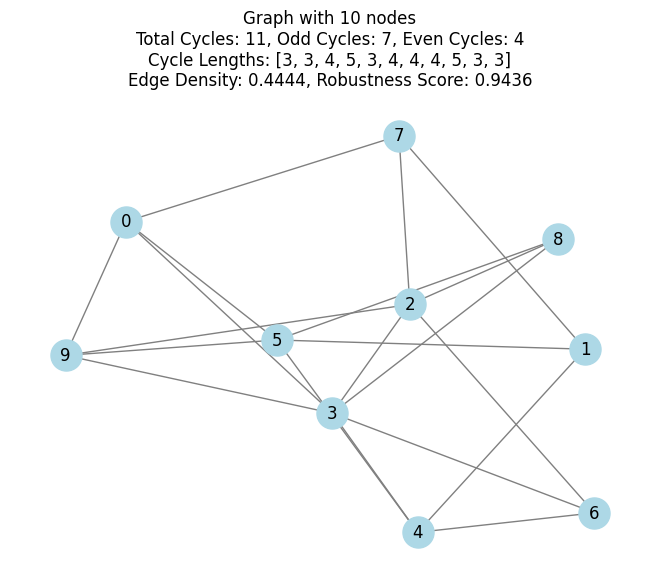

--------------------------------------------------
Graph 2:


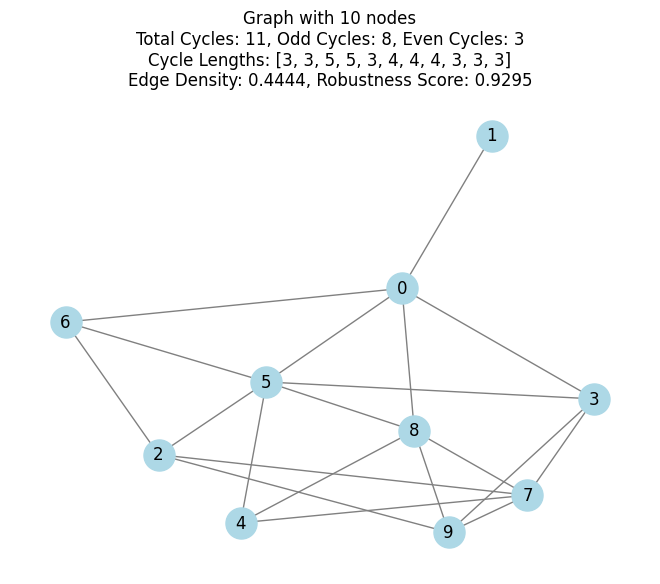

--------------------------------------------------
Graph 3:


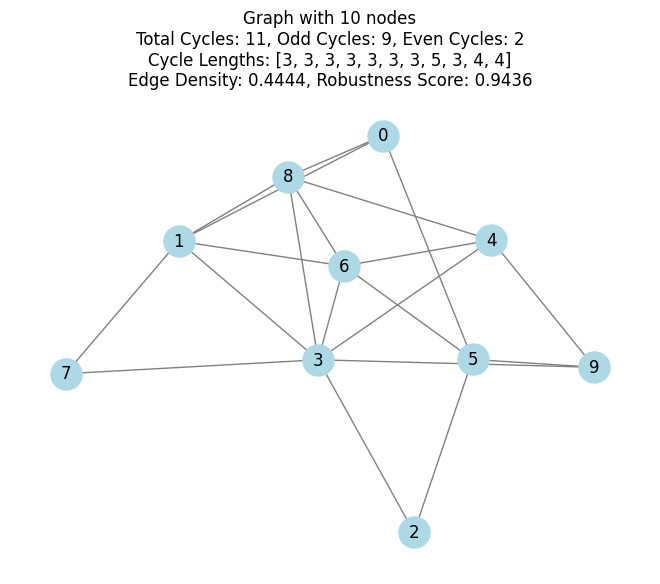

--------------------------------------------------
Graph 4:


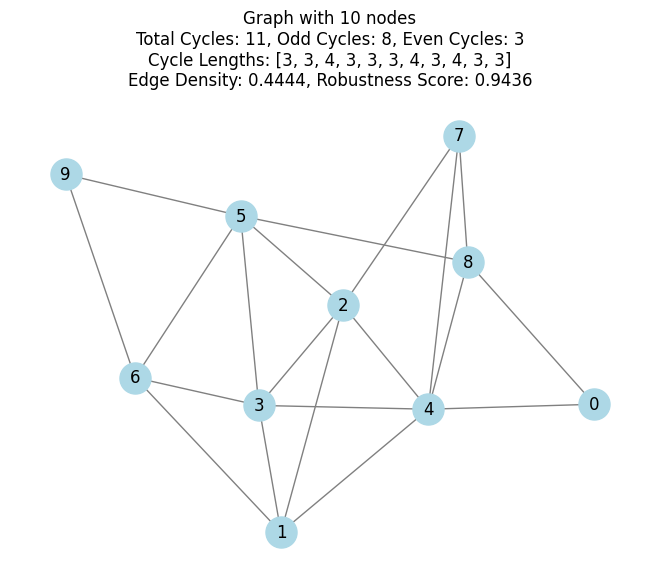

--------------------------------------------------
Graph 5:


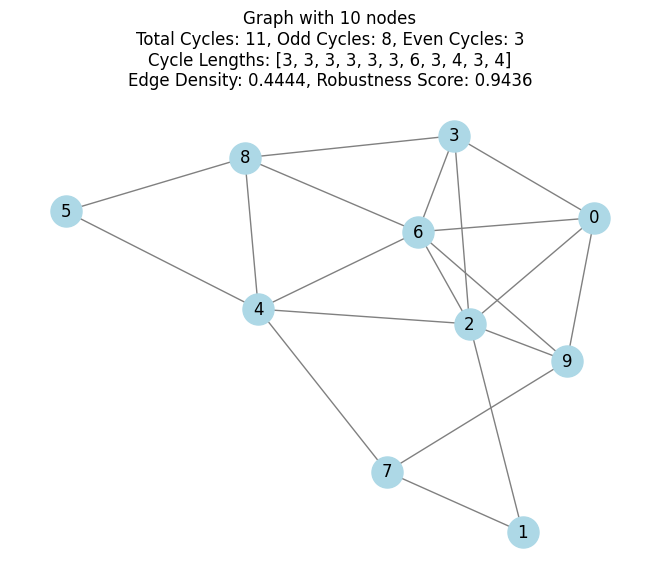

--------------------------------------------------


In [47]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def calculate_edge_density(G):
    E = G.number_of_edges()
    N = G.number_of_nodes()
    if N > 1:
        D = (2 * E) / (N * (N - 1))
    else:
        D = 0
    return D

def get_all_cycles(G):
    cycles = list(nx.cycle_basis(G))
    return cycles

def cycle_count_and_distribution(G):
    cycles = get_all_cycles(G)
    cycle_lengths = [len(cycle) for cycle in cycles]

    odd_cycles = [length for length in cycle_lengths if length % 2 == 1]
    even_cycles = [length for length in cycle_lengths if length % 2 == 0]

    return {
        "total_cycles": len(cycles),
        "odd_cycles": len(odd_cycles),
        "even_cycles": len(even_cycles),
        "cycle_lengths": cycle_lengths
    }

def calculate_robustness_score(G, perturbation_rate=0.05, trials=5):
    original_edge_density = calculate_edge_density(G)
    original_cycle_info = cycle_count_and_distribution(G)
    original_total_cycles = original_cycle_info['total_cycles']

    edge_density_changes = []
    cycle_changes = []

    for _ in range(trials):
        G_perturbed = G.copy()

        # Perturb the graph by randomly adding/removing edges
        num_edges_to_change = int(perturbation_rate * G.number_of_edges())

        edges = list(G.edges())
        nodes = list(G.nodes())

        for _ in range(num_edges_to_change):
            if np.random.rand() > 0.5 and len(edges) > 0:  # Remove an edge
                edge_to_remove = edges.pop(np.random.randint(len(edges)))
                G_perturbed.remove_edge(*edge_to_remove)
            else:  # Add a new edge
                node_pair = tuple(np.random.choice(nodes, 2, replace=False))
                if not G_perturbed.has_edge(*node_pair):
                    G_perturbed.add_edge(*node_pair)

        # Recalculate properties
        perturbed_edge_density = calculate_edge_density(G_perturbed)
        perturbed_cycle_info = cycle_count_and_distribution(G_perturbed)
        perturbed_total_cycles = perturbed_cycle_info['total_cycles']

        # Calculate changes
        edge_density_change = abs(perturbed_edge_density - original_edge_density) / original_edge_density
        cycle_change = abs(perturbed_total_cycles - original_total_cycles) / original_total_cycles

        edge_density_changes.append(edge_density_change)
        cycle_changes.append(cycle_change)

    # Robustness score as inverse of average relative change (lower change means higher robustness)
    average_edge_density_change = np.mean(edge_density_changes)
    average_cycle_change = np.mean(cycle_changes)

    robustness_score = 1 - (average_edge_density_change + average_cycle_change) / 2
    return robustness_score

def generate_and_evaluate_graph(n_nodes):
    # Generate a graph
    G = nx.gnm_random_graph(n_nodes, n_nodes * 2)

    # Calculate properties
    cycle_info = cycle_count_and_distribution(G)
    edge_density = calculate_edge_density(G)
    robustness_score = calculate_robustness_score(G)


    # Visualize the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
    plt.title(f"Graph with {n_nodes} nodes\nTotal Cycles: {cycle_info['total_cycles']}, "
              f"Odd Cycles: {cycle_info['odd_cycles']}, Even Cycles: {cycle_info['even_cycles']}\n"
              f"Cycle Lengths: {cycle_info['cycle_lengths']}\n"
              f"Edge Density: {edge_density:.4f}, Robustness Score: {robustness_score:.4f}")
    plt.show()

    return robustness_score

# Generate and evaluate the robustness score for 5 different graphs
for i in range(5):
    print(f"Graph {i+1}:")
    robustness_score = generate_and_evaluate_graph(10)  # Example with 10 nodes
    print("-" * 50)
